In [1]:
import context

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from hier_clust import HierClust

In [5]:
filename = "../../../2016-a-winter/cse250b-learning-algos/hw6/Animals_with_Attributes/predicate-matrix-continuous.txt"
df = np.loadtxt(filename)
df = sklearn.preprocessing.scale(df)  # TODO: is this needed?

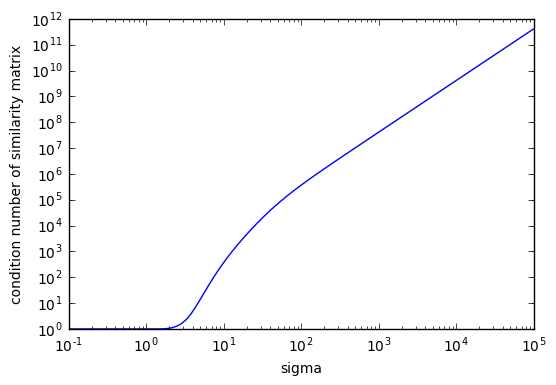

In [6]:
def sigma_to_cond(data, sigma):
    sim = HierClust(sigma_similarity = sigma)._get_similarity(data, sparse = 'never')
    return np.linalg.cond(sim)

sigmas = np.logspace(np.log10(0.1), np.log10(1e5), 100)
results = [sigma_to_cond(df, s) for s in sigmas]

plt.figure()
plt.loglog(sigmas, results) #, 'x')
#plt.loglog([2500], [sigma_to_cond(df, 2500)], 'o')
#plt.loglog([50], [sigma_to_cond(df, 50)], 'o')
plt.xlabel('sigma')
plt.ylabel('condition number of similarity matrix')

In [7]:
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
import scipy.cluster.hierarchy
from hier_clust import linkage_util

In [9]:
animals_filename = "../../../2016-a-winter/cse250b-learning-algos/hw6/Animals_with_Attributes/classes.txt"
with open(animals_filename) as f:
    animals = [line.split()[1].replace('+', ' ') for line in f]

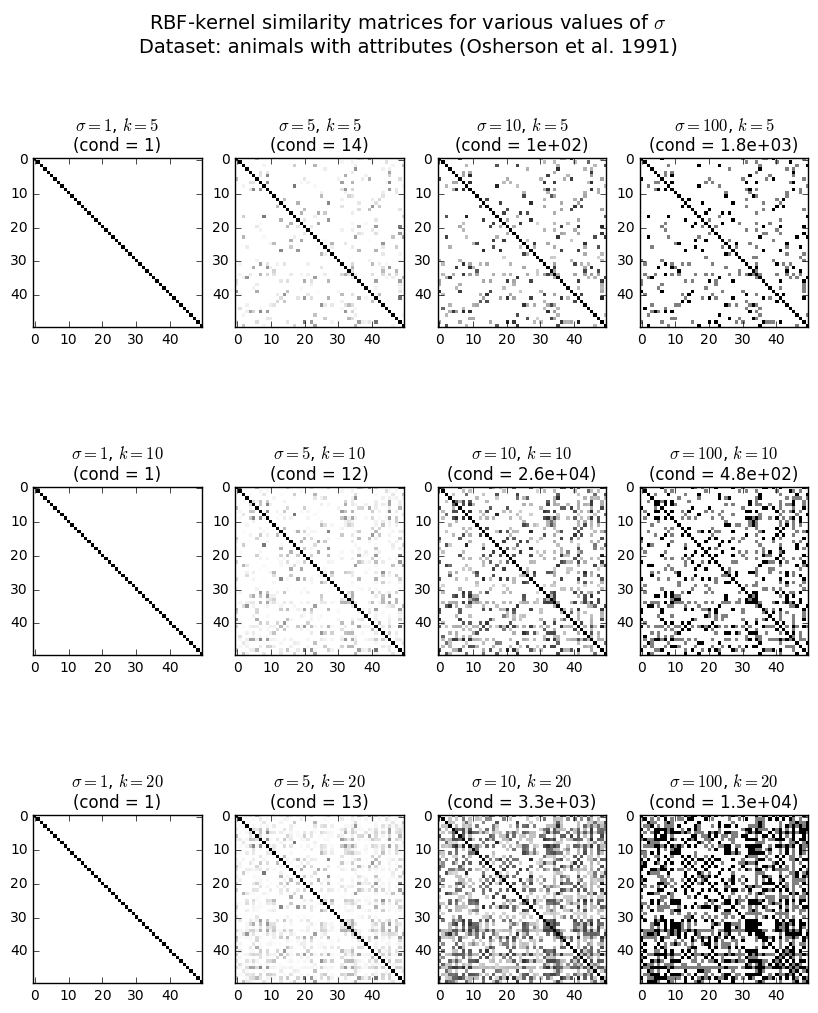

In [10]:
ks = [5, 10, 20]
sigmas = [1, 5, 10, 100]

fig, axes = plt.subplots(len(ks), len(sigmas))
fig.set_size_inches(2.5 * len(sigmas), 4 * len(ks), forward = True)
#fig.subplots_adjust(top=0.8)
fig.suptitle("RBF-kernel similarity matrices for various values of $\sigma$\nDataset: animals with attributes (Osherson et al. 1991)",
            fontsize = 14)

#fig2, axes2 = plt.subplots(len(ks), len(sigmas))
#fig2.set_size_inches(2.5 * len(sigmas), 4 * len(ks), forward = True)
#fig2.subplots_adjust(top=0.8)
#fig2.suptitle("Euclidean distance matrices", fontsize=14)

#fig3, axes3 = plt.subplots(len(ks), len(sigmas))
#fig3.set_size_inches(2.5 * len(sigmas), 7 * len(ks), forward = True)
#fig3.subplots_adjust(top=0.8)
#fig3.suptitle("Trees", fontsize=14)

for i, k in enumerate(ks):
    for j, s in enumerate(sigmas):
        distsq = euclidean_distances(df, squared = True) / (2. * s ** 2)
        hc = HierClust(n_neighbors = k, sigma_similarity = s, mutual_neighbors = False)
        #sim = hc._get_dense_similarity(df)
        sim = hc._get_similarity(df, sparse = 'always').todense()
        #sim2 = rbf_kernel(df, gamma = 1. / (2. * s ** 2))
        #sim3 = np.exp(-distsq)
        #assert np.allclose(sim, sim2)
        #assert np.allclose(sim2, sim3)
        cond = np.linalg.cond(sim)
        distsq_cond = np.linalg.cond(distsq)
        axes[i, j].imshow(sim, interpolation = 'nearest', cmap='gray_r', vmin=0, vmax=1)
        axes[i, j].set_title("$\sigma = {}$, $k = {}$\n(cond = {:.2g})".format(s, k, cond))

        #axes2[i, j].imshow(distsq, interpolation = 'nearest', cmap='gray_r')
        #axes2[i, j].set_title("$\sigma = {}$, $k = {}$\nrange of $d^2/(2\sigma^2)$:\n{} to {:.2f}\n(cond = {:.2f})".format(s, k, np.min(distsq), np.max(distsq), distsq_cond))
    
        #tree, _ = hc.fit(df)
        #linkage = linkage_util.get_linkage(tree)
        #scipy.cluster.hierarchy.dendrogram(linkage, labels = animals, color_threshold = 0,
        #                                   orientation = 'left', ax = axes3[i, j])
        #axes3[i, j].set_title("$\sigma = {}$, $k = {}$".format(s, k))
    
#fig.savefig("./rbf-similarity-matrices.pdf")

In [11]:
import ipywidgets
from IPython.display import display

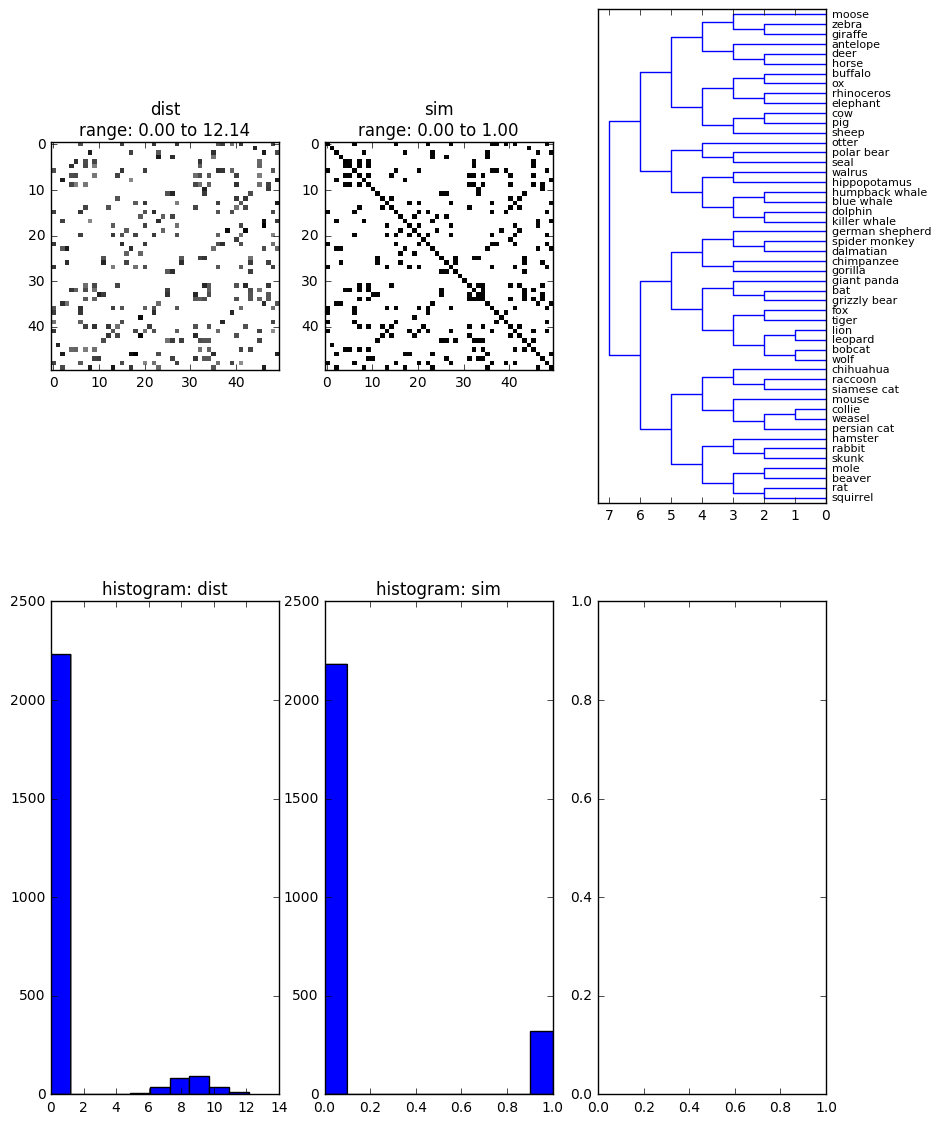

In [15]:
def plotter(
        k = 10,
        sigma = 8.0,
        auto_sigma = True,
        alpha = 0.8,
        sparse = 'never',
        mutual_neighbors = False,
        seed = 1):
    np.random.seed(seed)
    fig, axes = plt.subplots(2, 3)
    fig.set_size_inches(10, 14, forward=True)

    if auto_sigma:
        sigma = 'auto'
    hc = HierClust(
        n_neighbors = k,
        sigma_similarity = sigma,
        mutual_neighbors = mutual_neighbors,
        sparse_similarity = sparse,
        alpha = alpha)

    specs = [
        {'name': 'dist', 'func': hc._get_distances,  'ax_index': 0, 'hist_xlim': None, 'imshow_args': {}},
        {'name': 'sim',  'func': hc._get_similarity, 'ax_index': 1, 'hist_xlim': (0, 1), 'imshow_args': dict(vmin=0, vmax=1)},
    ]
    for spec in specs:
        matrix = spec['func'](df, sparse = sparse)
        if hasattr(matrix, 'todense'): matrix = matrix.todense()
        matrix = np.nan_to_num(matrix)
        axes[0, spec['ax_index']].imshow(matrix, interpolation='nearest', cmap='gray_r', **spec['imshow_args'])
        axes[0, spec['ax_index']].set_title("{}\nrange: {:.2f} to {:.2f}".format(spec['name'], np.min(matrix), np.max(matrix)))
        
        axes[1, spec['ax_index']].hist(matrix.reshape(-1, 1))
        if spec['hist_xlim'] is not None:
            axes[1, spec['ax_index']].set_xlim(*spec['hist_xlim'])
        axes[1, spec['ax_index']].set_title('histogram: {}'.format(spec['name']))
    
    tree, _ = hc.fit(sim)
    linkage = linkage_util.get_linkage(tree)
    scipy.cluster.hierarchy.dendrogram(linkage, labels = animals, color_threshold = 0,
                                       orientation = 'left', ax = axes[0,2])
    plt.show()
    #display(fig)

sparse_choices = ('auto', 'never')
w = ipywidgets.interact(plotter,
                        k = (2, 50),
                        sigma = (1., 100.),
                        sparse = sparse_choices,
                        seed = (1, 100),
                        alpha = (0.01, 0.99, 0.01),
                        mutual_neighbors = True,
                        auto_sigma = True,
                       #__manual = True,
                       )